In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

VER = 1
FIRST_FOLD_ONLY = True
TRAIN_MODEL = True

In [ ]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau

import pandas as pd, numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error

import math 
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns

import gc

# Load Data and Feature Engineer

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
train = pd.read_csv('/content/drive/MyDrive/ECE 570/train (1).csv')

In [ ]:
train.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


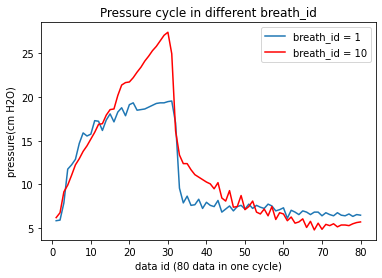

In [ ]:
x = np.linspace(1,80,80)
plt.xlabel("data id (80 data in one cycle)")
plt.ylabel("pressure(cm H2O)")
plt.title("Pressure cycle in different breath_id")
plt.plot(x,train["pressure"][0:80],label = "breath_id = 1")
plt.plot(x,train["pressure"][800:880], color ="r",label = "breath_id = 10")
plt.legend()
plt.show()

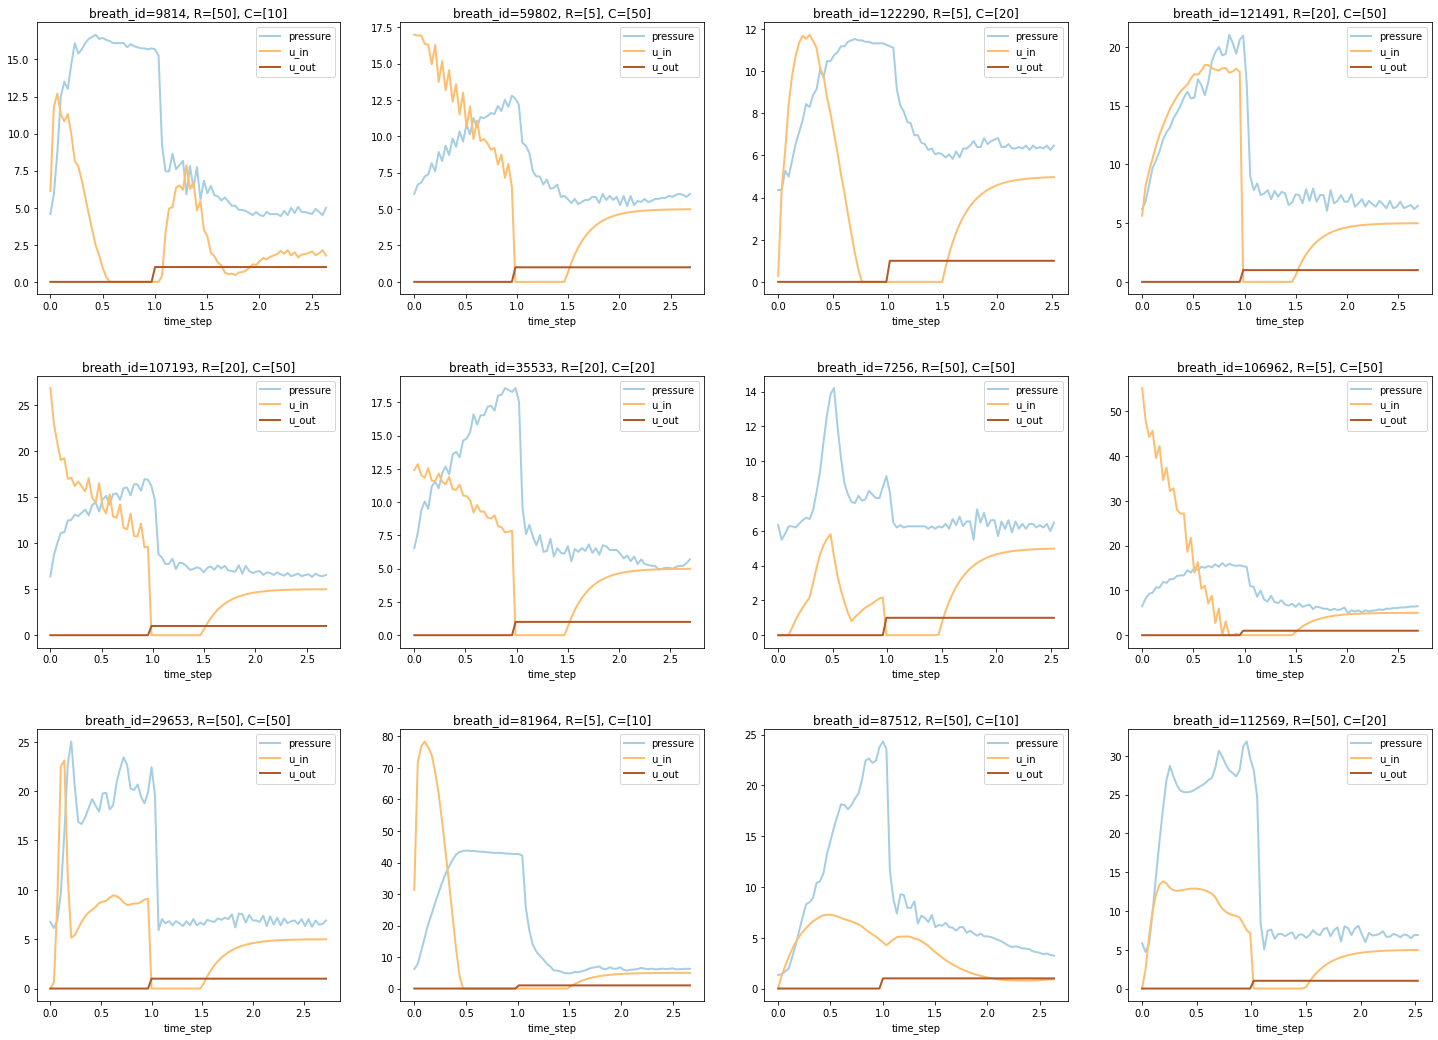

In [ ]:
breath_ids = list(train["breath_id"].sample(12))
fig, axes = plt.subplots(figsize=(25, 18), ncols=4, nrows=3)
axes = np.ravel(axes)
for b, ax in zip(breath_ids, axes):
    _df = train[train["breath_id"]==b].copy()
    (_df
     .set_index("time_step")[["pressure", "u_in", "u_out"]]
     .plot(colormap='Paired',
           ax=ax,
           title=f"breath_id={b}, R={_df['R'].unique()}, C={_df['C'].unique()}", 
           linewidth=2)
    )
    
fig.subplots_adjust(hspace=0.3)

In [ ]:
def add_features(df):
    
    #Step 1: Making muliplicative or cumulative fatures
    df['cross']= df['u_in'] * df['u_out']
    df['cross2']= df['time_step'] * df['u_out']
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby(['breath_id'])['area'].cumsum()
    df['time_step_cumsum'] = df.groupby(['breath_id'])['time_step'].cumsum()
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    print("Step-1...Completed")
    
    #Step 2: Calculation of lag features 
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    print("Step-2...Completed")
    
    #Step 3: Calculation of mean, max of u_in
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_in__mean'] = df.groupby(['breath_id'])['u_in'].transform('mean')
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']

    print("Step-3...Completed")
    
    #Step 4: Calculation of differences between u_in and u_in_lag
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    print("Step-4...Completed")
    
    #Step 5: Calculation of mean value of cumulative u_in
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']
    
    print("Step-5...Completed")
    
    #Step 6: Calculation of rolling parameters (EWM, MA)
    df['time_step_diff'] = df.groupby('breath_id')['time_step'].diff().fillna(0)
    df['ewm_u_in_mean'] = (df\
                           .groupby('breath_id')['u_in']\
                           .ewm(halflife=9)\
                           .mean()\
                           .reset_index(level=0,drop=True))
    df[["15_in_sum","15_in_min","15_in_max","15_in_mean"]] = (df\
                                               .groupby('breath_id')['u_in']\
                                              .rolling(window=15,min_periods=1)\
                                                .agg({"15_in_sum":"sum",
                                                     "15_in_min":"min",
                                                    "15_in_max":"max",
                                                    "15_in_mean":"mean"
                                                                    #"15_in_std":"std"
                                                               })\
                                                               .reset_index(level=0,drop=True))
    print("Step-6...Completed")
    
    #Step 7: Calculation of differences between u_in and u_in_lag_back
    df['u_in_lagback_diff1'] = df['u_in'] - df['u_in_lag_back1']
    df['u_out_lagback_diff1'] = df['u_out'] - df['u_out_lag_back1']
    df['u_in_lagback_diff2'] = df['u_in'] - df['u_in_lag_back2']
    df['u_out_lagback_diff2'] = df['u_out'] - df['u_out_lag_back2']
    print("Step-7...Completed")
    
    #Step 8: One hot encoding for categorival features
    df['R'] = df['R'].astype(str)
    df['C'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    print("Step-8...Completed")
    
    return df

In [ ]:
train_add = add_features(train)


Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-6...Completed
Step-7...Completed
Step-8...Completed


In [ ]:
print('Train shape is now:', train_add.shape )
train_add.head()

Train shape is now: (6036000, 66)


,id,breath_id,time_step,u_in,u_out,pressure,cross,cross2,area,u_in_lag1,...,C_50,R__C_20__10,R__C_20__20,R__C_20__50,R__C_50__10,R__C_50__20,R__C_50__50,R__C_5__10,R__C_5__20,R__C_5__50
0,1,1,0.000000,0.083334,0,5.837492,0.0,0.0,0.000000,0.000000,...,1,0,0,1,0,0,0,0,0,0
1,2,1,0.033652,18.383041,0,5.907794,0.0,0.0,0.618632,0.083334,...,1,0,0,1,0,0,0,0,0,0
2,3,1,0.067514,22.509278,0,7.876254,0.0,0.0,1.519701,18.383041,...,1,0,0,1,0,0,0,0,0,0
3,4,1,0.101542,22.808822,0,11.742872,0.0,0.0,2.316059,22.509278,...,1,0,0,1,0,0,0,0,0,0
4,5,1,0.135756,25.355850,0,12.234987,0.0,0.0,3.442197,22.808822,...,1,0,0,1,0,0,0,0,0,0


#Reshape the input data and output data as 80 rows per cycle

In [ ]:
train_add['pressure_diff'] = train_add.groupby('breath_id').pressure.diff().fillna(0)
train_add['pressure_integral'] = train_add.groupby('breath_id').pressure.cumsum()/200
targets = train_add[['pressure','pressure_diff','pressure_integral']].to_numpy().reshape(-1, 80, 3)
train_add.drop(['pressure','pressure_diff','pressure_integral','id', 'breath_id','one','count'], axis=1, inplace=True)

In [ ]:
targets = train_add['pressure'].to_numpy().reshape(-1, 80, 1)
train_add.drop(['pressure','pressure_diff','pressure_integral','id', 'breath_id','one','count',"time_step"], axis=1, inplace=True)

In [ ]:
print("Train shape is",train_add.shape)
print('Targets shape is',targets.shape)

Train shape is (6036000, 62)
Targets shape is (75450, 80, 3)


#Scale data

In [ ]:
RS = RobustScaler()
train_scale = RS.fit_transform(train_add.astype('float32'))

train_regroup = train_scale.reshape(-1, 80, train_scale.shape[-1])

print("The train regroup every 80 rows:",train_regroup.shape)

The train regroup every 80 rows: (75450, 80, 62)


In [ ]:
U_OUT_IDX = 2
y_weight = np.ones_like( targets )
u_out_values = train_regroup[:,:,U_OUT_IDX]
y_weight[ u_out_values==0 ] = 0 # because robust scaler changes 1 to 0

In [ ]:
train_regroup.shape, targets.shape, y_weight.shape

((75450, 80, 62), (75450, 80, 3), (75450, 80, 3))

#GPU

In [ ]:
if os.environ["CUDA_VISIBLE_DEVICES"].count(',') == 0:
    gpu_strategy = tf.distribute.get_strategy()
    print('single strategy')

single strategy


In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, feat_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="gelu"), layers.Dense(feat_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
feat_dim = train_regroup.shape[-1] + 32
embed_dim = 64  # Embedding size for attention
num_heads = 8  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer
dropout_rate = 0.0
num_blocks = 12

def build_model():
    inputs = layers.Input(shape=train_regroup.shape[-2:])
        
    # "EMBEDDING LAYER"
    x = layers.Dense(feat_dim)(inputs)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    
    # TRANSFORMER BLOCKS
    for k in range(num_blocks):
        x_old = x
        transformer_block = TransformerBlock(embed_dim, feat_dim, num_heads, ff_dim, dropout_rate)
        x = transformer_block(x)
        x = 0.7*x + 0.3*x_old # SKIP CONNECTION
    
    # REGRESSION HEAD
    x = layers.Dense(128, activation="selu")(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(3, activation="linear")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
        
    return model

Learning rate schedule: 0.0006 to 0.0006 to 1e-06


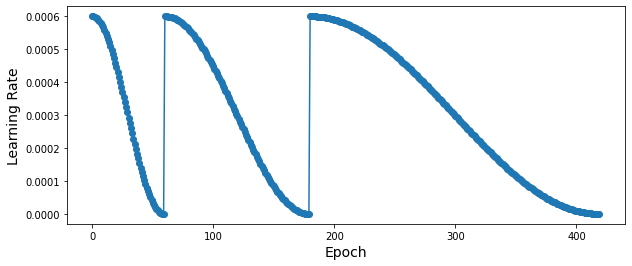

In [ ]:
LR_START = 1e-6
LR_MAX = 6e-4
LR_MIN = 1e-6
LR_RAMPUP_EPOCHS = 0
LR_SUSTAIN_EPOCHS = 0
EPOCHS = 420
STEPS = [60,120,240]


def lrfn(epoch):
    if epoch<STEPS[0]:
        epoch2 = epoch
        EPOCHS2 = STEPS[0]
    elif epoch<STEPS[0]+STEPS[1]:
        epoch2 = epoch-STEPS[0]
        EPOCHS2 = STEPS[1]
    elif epoch<STEPS[0]+STEPS[1]+STEPS[2]:
        epoch2 = epoch-STEPS[0]-STEPS[1]
        EPOCHS2 = STEPS[2]
    
    if epoch2 < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch2 + LR_START
    elif epoch2 < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch2 - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
          format(lr_y[0], max(lr_y), lr_y[-1]))
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
plt.xlabel('Epoch',size=14)
plt.ylabel('Learning Rate',size=14)
plt.show()

#Train model

In [ ]:
EPOCH = 3 #EPOCHS  ==> examples
BATCH_SIZE = 64
NUM_FOLDS = 11
SEED = 42
VERBOSE = 1
import time
start_time = time.time()
with gpu_strategy.scope():
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
    
    test_preds = []
    oof_preds = []
    oof_true = []
    all_mask = []
    test_folds = []
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(train_regroup, targets)):
        print('-'*15, '>', f'Fold {fold+1}', '<', '-'*15)
        X_train, X_valid = train_regroup[train_idx], train_regroup[test_idx]
        y_train, y_valid = targets[train_idx], targets[test_idx]
        test_folds.append(test_idx)
                
        checkpoint_filepath = f"folds{fold}_{VER}.hdf5"

        model = build_model()
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(optimizer=opt, loss="mae", sample_weight_mode="temporal")

        sv = keras.callbacks.ModelCheckpoint(
                checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
                save_weights_only=True, mode='auto', save_freq='epoch',
                options=None


        )


        if TRAIN_MODEL:
            history = model.fit(X_train, y_train, verbose=VERBOSE,
                                validation_data=(X_valid, y_valid, y_weight[test_idx,:,:1]), 
                                epochs=EPOCH, batch_size=BATCH_SIZE, callbacks=[lr_callback, sv], 
                                sample_weight = y_weight[train_idx,:,:1])
        

        else:
            model.load_weights(f'./folds{fold}_{VER}.hdf5')
       
        # PREDICT OOF
        # print('Predicting OOF...')
        # oof_preds.append( model.predict(X_valid, verbose=VERBOSE)[:,:,0].squeeze().reshape(-1, 1) )
        # oof_true.append( y_valid[:,:,0].squeeze().reshape(-1, 1) )
        # score = mean_absolute_error(oof_true[-1], oof_preds[-1])
        # print(f"Fold-{fold+1} | OOF all u_out Score: {score}")
        
        # mask = np.where( X_valid[:,:,2].reshape((-1,1))==-1 )[0]
        # mask_score = mean_absolute_error(oof_true[-1][mask], oof_preds[-1][mask])
        # print(f"Fold-{fold+1} | OOF u_out=0 Score: {mask_score}")
        # all_mask.append(mask)
        
        # np.save(f'oof_v{VER}_trans',oof_preds)
        #np.save(f'oof_true_v{VER}_trans',oof_true)
        
        if FIRST_FOLD_ONLY: break
end_time = time.time()

--------------- > Fold 1 < ---------------

Epoch 1: LearningRateScheduler setting learning rate to 0.0006.
Epoch 1/3
1072/1072 [==============================] - ETA: 0s - loss: 0.2947


Epoch 1: val_loss improved from inf to 0.18257, saving model to folds0_1.hdf5
1072/1072 [==============================] - 70s 54ms/step - loss: 0.2947 - val_loss: 0.1826 - lr: 6.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0005995755173551901.
Epoch 2/3
1071/1072 [============================>.] - ETA: 0s - loss: 0.1651


Epoch 2: val_loss improved from 0.18257 to 0.14645, saving model to folds0_1.hdf5
1072/1072 [==============================] - 54s 51ms/step - loss: 0.1651 - val_loss: 0.1465 - lr: 5.9958e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.000598303272662936.
Epoch 3/3
1071/1072 [============================>.] - ETA: 0s - loss: 0.1458


Epoch 3: val_loss improved from 0.14645 to 0.13305, saving model to folds0_1.hdf5
1072/1072 [==============================] - 54s 50ms/step - loss: 0.1458 - val_loss: 0.1330 - lr: 5.9830e-04


# Plot Train Loss Valid Loss

[1. 2. 3.]


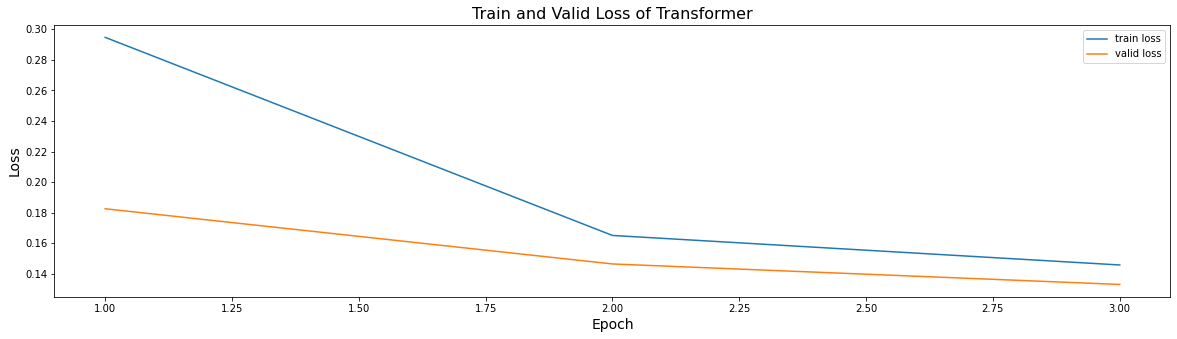

In [ ]:
# PLOT TRAIN AND VAL HISTORY
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
val = history.history['val_loss']
trn = history.history['loss']
x = np.linspace(1,EPOCH,EPOCH)
print(x)
plt.plot(x,trn,label='train loss')
plt.plot(x,val,label='valid loss')
plt.xlabel('Epoch',size=14)
plt.ylabel('Loss',size=14)
plt.title('Train and Valid Loss of Transformer',size=16)
plt.legend()
plt.show()

In [ ]:
def draw_result(start_id, end_id, target, y_pred):
  start_id1 = start_id -1
  end_id1 = end_id + 1  
  plt.figure(figsize = (20, 7))
  plt.plot(target[start_id1: end_id1,:,0].reshape(-1,1), linewidth=5, label = "actual Pressure values")
  plt.plot(y_pred[start_id1: end_id1,:,0].reshape(-1,1), linewidth=2, label = "predict Pressure values")
  plt.xlabel("Times")
  plt.ylabel("Pressure")
  plt.title(f"Transformer test_{start_id}_id--test_{end_id}_id")
  plt.legend()

In [ ]:
y_pred = model.predict(X_valid)

215/215 [==============================] - 6s 22ms/step


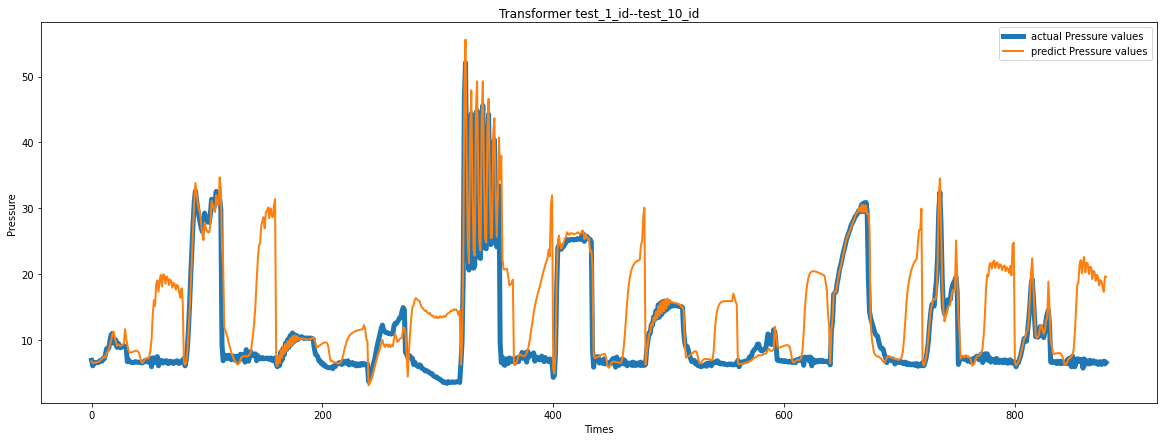

In [ ]:
draw_result( 1,10, y_valid, y_pred)

In [ ]:
cost_time = end_time - start_time
print(f"Time for Training model:%.2f s"%cost_time)

Time for Training model:192.70 s


In [ ]:
from sklearn.metrics import r2_score
y_v = y_valid[:,:,0].reshape(-1,1)
y_p = y_pred[:,:,0].reshape(-1,1)
print(y_p.shape)
R_square = r2_score(y_v,y_p)
print("R^2 of the Transformer model is:",R_square)

(548800, 1)
R^2 of the Transformer model is: 0.0314845744046528


In [ ]:
print(y_v.shape)
y_mean = np.mean(y_v)
y_mean_a = np.full(y_v.shape, y_mean)
print(y_mean_a)

(548800, 1)
[[11.20206152]
 [11.20206152]
 [11.20206152]
 ...
 [11.20206152]
 [11.20206152]
 [11.20206152]]


In [ ]:

bias = np.sum((y_p - y_v)**2)

Total = np.sum((y_v - y_mean_a)**2)
Rsquare = 1- (bias/Total)
print(Rsquare)

[[-0.13663706]
 [ 0.43158567]
 [-0.04638732]
 ...
 [16.55670277]
 [15.58325987]
 [14.49906869]]
34570717.669053964
0.0314845744046528
